In [1]:
import cv2
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
camcali_images = glob.glob('camera_cal/calibration*.jpg')

#function for camera calibration prepartion
def camera_cali_prep(nx, ny):
    objpoints = []
    imgpoints = []
    notfound_corners = []
    #prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #going through the list of all camera calibration images
    for index, item in enumerate(camcali_images):
        cali_img_temp = cv2.imread(item)
        gray_cali = cv2.cvtColor(cali_img_temp, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_cali, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(cali_img_temp, (nx, ny), corners, ret)
        else:
            notfound_corners.append(item)
    
    #print the picture that cv2 failed to detect the corners of a chessboard
    plt.figure(figsize=(12,4))
    plt.figtext(0.5,0.9,'Images in which 9x5 corners(part of the corners sheltered)', fontsize=22, ha='center')
    print()
    cali_img_temp1 = cv2.imread(notfound_corners[0])
    imgsize = cali_img_temp1.shape
    print(imgsize)
    gray_cali1 = cv2.cvtColor(cali_img_temp1, cv2.COLOR_BGR2GRAY)
    ret1, corners1 = cv2.findChessboardCorners(gray_cali1, (9,5), None)
    if ret1 == True:
        notfound_corners.remove(notfound_corners[0])
        cv2.drawChessboardCorners(cali_img_temp1, (9,5), corners1, ret1)
    plt.imshow(cali_img_temp1)

    plt.figure(figsize=(15,5))
    plt.figtext(0.5,0.85,'Images in which cv2 failed to detect corners ', fontsize=22, ha='center')
    plt.subplot(1,2,1)
    plt.imshow(cv2.imread(notfound_corners[0]))
    plt.subplot(1,2,2)
    plt.imshow(cv2.imread(notfound_corners[1]))
    
    print(notfound_corners)
    return objpoints, imgpoints, imgsize


(720, 1280, 3)
['camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg']


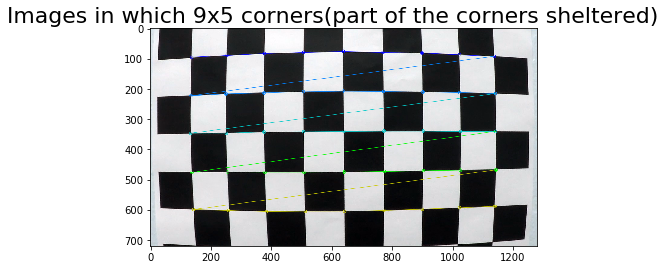

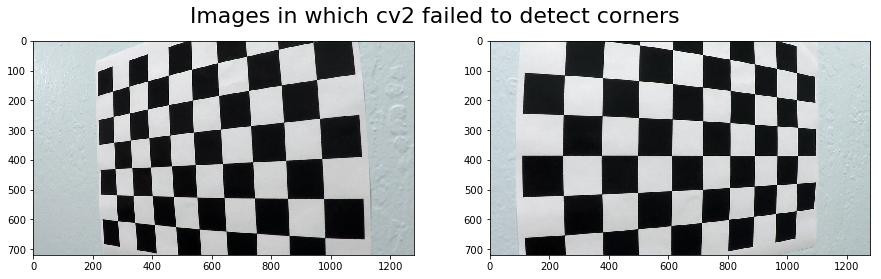

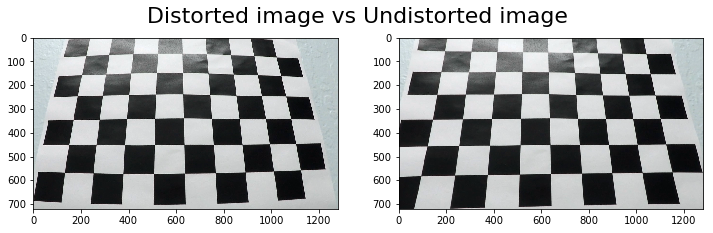

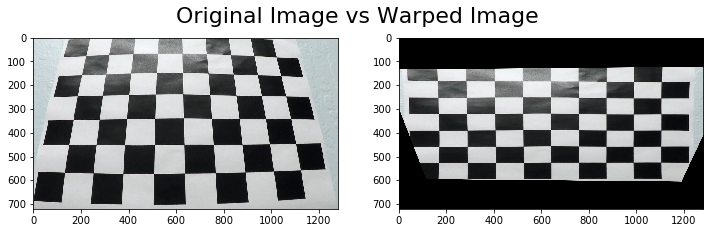

In [3]:
#calibration and undistort function
def cali_undistort(offset, nx, imgsize):
    cali_imagesize = (imgsize[1], imgsize[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cali_imagesize, None, None)
    #test image used for prespective transform and undistortion
    test_img = cv2.imread('./camera_cal/calibration3.jpg')
    gray_test = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    
    #prespective transform
    ret, corners = cv2.findChessboardCorners(gray_test, (9,6), None)
    src_coord = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
    dst_coord = np.float32([[offset,offset],[cali_imagesize[0]-offset,offset], \
                            [cali_imagesize[0]-offset,cali_imagesize[1]-offset],[offset,cali_imagesize[1]-offset]])
    M_chess = cv2.getPerspectiveTransform(src_coord, dst_coord)
    
    #undistortion and plot
    plt.figure(figsize=(12,4))
    plt.figtext(0.5,0.85, 'Distorted image vs Undistorted image', fontsize=22, ha='center')
    plt.subplot(1,2,1)
    plt.imshow(test_img)
    cv2.imwrite('output_images/original_cali.jpg', test_img)
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/undistortedimagetest.jpg',dst)
    plt.subplot(1,2,2)
    plt.imshow(dst)
    
    #prespective plot
    warped = cv2.warpPerspective(dst, M_chess, cali_imagesize)
    cv2.imwrite('output_images/warped_cali.jpg', warped)
    plt.figure(figsize=(12,4))
    plt.figtext(0.5,0.85, 'Original Image vs Warped Image', fontsize=22, ha='center')
    plt.subplot(1,2,1)
    plt.imshow(test_img)
    plt.subplot(1,2,2)
    plt.imshow(warped)
    
    # M for bird eye view, used for lanelines prespective transform
    src = np.float32 ([
        [220, 651],
        [350, 577],
        [828, 577],
        [921, 651]
    ])

    dst = np.float32 ([
            [220, 651],
            [220, 577],
            [921, 577],
            [921, 651]
        ])
    M_bird = cv2.getPerspectiveTransform(src, dst)
    M_bird_inv = cv2.getPerspectiveTransform(dst, src)
    #store the caliration data and save it into .p file
    cali_data_pickle = {}
    cali_data_pickle["mtx"] = mtx
    cali_data_pickle["dist"] = dist
    cali_data_pickle["ret"] = ret
    cali_data_pickle["M_bird"] = M_bird
    cali_data_pickle['M_bird_inv'] = M_bird_inv
    pickle.dump(cali_data_pickle, open("camera_calibration_data.p", "wb"))
    return ret, mtx, dist, M_bird, M_bird_inv

#camera callibration
objpoints, imgpoints, imgsize = camera_cali_prep(9,6)
ret, mtx, dist, M_bird, M_bird_inv = cali_undistort(200, 9, imgsize)


In [4]:

#read the calibration data from .p file
cali_data = pickle.load(open("camera_calibration_data.p", "rb"))
print('M_bird saved is :',cali_data["M_bird"])
print('M_bird as an function output is:', M_bird)

M_bird saved is : [[ -5.55997385e-01  -1.50258845e+00   9.78185082e+02]
 [  3.99680289e-15  -1.93512256e+00   8.97810491e+02]
 [  7.80625564e-18  -2.39016495e-03   1.00000000e+00]]
M_bird as an function output is: [[ -5.55997385e-01  -1.50258845e+00   9.78185082e+02]
 [  3.99680289e-15  -1.93512256e+00   8.97810491e+02]
 [  7.80625564e-18  -2.39016495e-03   1.00000000e+00]]


image shape is: (720, 1280, 3)


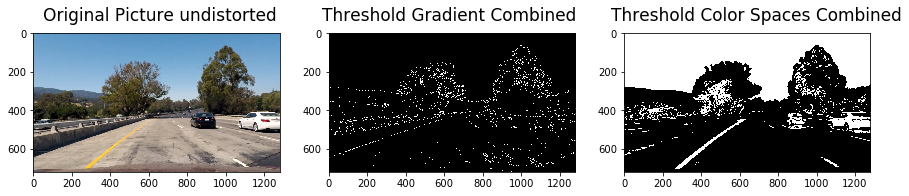

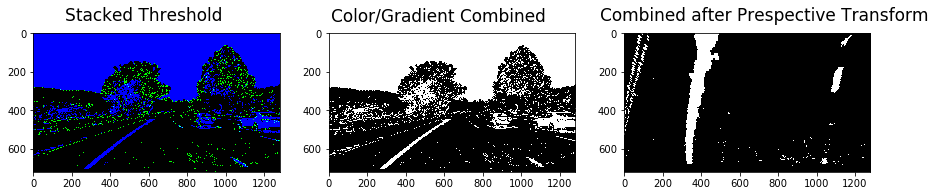

In [5]:
#Thresholding(using )
def Thresholding(img, M_bird):
    # using camera calibration function to undistort and warp the image
    
    img_size = (img.shape[1], img.shape[0])
    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
#     img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
#     img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
#     img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
#     img = cv2.GaussianBlur(img,(5,5),20.0)
    # Threshold Gradient: Magnitude, Direction, absoulute value
    gray_test = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calcualte the Soble derivative
    sobelx = cv2.Sobel(gray_test, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sobely = cv2.Sobel(gray_test, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold Gradient Absoulute Value
    thresh_abs = (20, 100)
    binary_gradabs = np.zeros_like(scaled_sobely)
    binary_gradabs[(scaled_sobelx >= thresh_abs[0]) & (scaled_sobelx <= thresh_abs[1]) \
                   & (scaled_sobely >=thresh_abs[0]) & (scaled_sobely <= thresh_abs[1])] = 1

    # Thresholod Gradient Magnitude
    thresh_mag = (30, 100)
    mag_sob = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(mag_sob)/255
    mag_sob = (mag_sob/scale_factor).astype(np.uint8)
    binary_gradmag = np.zeros_like(mag_sob)
    binary_gradmag[(mag_sob > thresh_mag[0]) & (mag_sob < thresh_mag[1])] = 1

    # Threshold Gradient Direction
    thresh_dir = (0.7, 1.3)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_dir = np.zeros_like(dir_grad)
    binary_dir[(dir_grad > thresh_dir[0]) & (dir_grad < thresh_dir[1])] = 1

    # Threshold Gradient Combined
    grad_combined = np.zeros_like(binary_dir)
    grad_combined[((binary_dir == 1)&(binary_gradmag == 1)) | (binary_gradabs == 1)] = 1
    

    # Threshold color channel (R, gray, H, S)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Threshold H channel in hls
    thresh_H = (15, 100)
    H_space = hls[:,:,0]
    H_binary = np.zeros_like(H_space)
    H_binary[(H_space > thresh_H[0]) & (H_space <= thresh_H[1])] = 1

    # Threshold S channel in hls
    thresh_S = (90, 255)
    S_space = hls[:,:,2]
    S_binary = np.zeros_like(S_space)
    S_binary[(S_space > thresh_S[0]) & (S_space <= thresh_S[1])] = 1

    # Threshold gray scale
#     thresh_gray = (180,255)
#     gray_binary = np.zeros_like(gray_test)
#     gray_binary[(gray_test > thresh_gray[0]) & (gray_test <= thresh_gray[1])] = 1

    # Threshold R in RGB
    thresh_R=(200,255)
    R_space = img[:,:,1]
    R_binary = np.zeros_like(R_space)
    R_binary[(R_space > thresh_R[0]) & (R_space <= thresh_R[1])] = 1

    # Threshold Color Spaces Combined
    # Do not use gray threshold
    # Use only S threshold and R threshold performs better than the other combination
    color_combined = np.zeros_like(R_binary)
    color_combined[(R_binary == 1) | (S_binary == 1)] = 1

    # Final Output
    final_show = np.dstack(( np.zeros_like(color_combined), grad_combined, color_combined))
    final_binary = np.zeros_like(color_combined)
    final_binary[(color_combined == 1) | (grad_combined == 1)] = 1
    
    # Bird eye Presprctive Transform
    combined_pres_trans = cv2.warpPerspective(final_binary, M_bird, img_size)
    
    return final_show, final_binary, combined_pres_trans, grad_combined, color_combined

test_image = mpimg.imread("./test_images/test1.jpg")
print('image shape is:', test_image.shape)
final_show, threshold_out, birdeye_lanelines, grad_combined, color_combined = Thresholding(test_image, M_bird)
test_image_undistort = cv2.undistort(test_image, mtx, dist, None, mtx)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.figtext(0.35, 0.73, 'Original Picture undistorted', fontsize=17, ha='right')
plt.imshow(test_image_undistort)
plt.subplot(1,3,2)
plt.figtext(0.51, 0.73, 'Threshold Gradient Combined', fontsize=17, horizontalalignment='center')
plt.imshow(grad_combined, cmap='gray')
plt.subplot(1,3,3)
plt.figtext(0.66, 0.73, 'Threshold Color Spaces Combined', fontsize=17, horizontalalignment='left')
plt.imshow(color_combined, cmap='gray')
    
# Plot the three picture got
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
# final_show.save('output_images/stacked_thresh.jpg')
# cv2.imwrite('output_images/stacked_thresh.jpg', final_show)
plt.figtext(0.3, 0.73, 'Stacked Threshold', fontsize=17, ha='right')
plt.imshow(final_show)
plt.subplot(1,3,2)
plt.figtext(0.5, 0.73, 'Color/Gradient Combined', fontsize=17, ha='center')
plt.imshow(threshold_out, cmap='gray')
plt.subplot(1,3,3)
plt.figtext(0.65, 0.73, 'Combined after Prespective Transform', fontsize=17, ha='left')
plt.imshow(birdeye_lanelines, cmap='gray')


In [6]:
# Measure curvature function
def measure_curvature(leftx, rightx, lefty, righty, ploty, order_l, order_r):
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    left_fit_rlw = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, order_l)
    right_fit_rlw = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, order_r)

    y_eval = np.max(ploty)*ym_per_pix
    if order_l == 2:
        left_curved = ((1+(2*left_fit_rlw[0]*y_eval+left_fit_rlw[1])**2)**1.5)/np.absolute(2*left_fit_rlw[0])
    elif order_l == 1:
        left_curved = 9999
    else:
        left_curved = ((1+(3*left_fit_rlw[0]*(y_eval**2)+2*left_fit_rlw[1]+left_fit_rlw[2])**2)**1.5) \
        /np.absolute(6*left_fit_rlw[0]*y_eval + 2*left_fit_rlw[1])
    if order_r == 2:
        right_curved = ((1+(2*right_fit_rlw[0]*y_eval+right_fit_rlw[1])**2)**1.5)/np.absolute(2*right_fit_rlw[0])
    elif order_r == 1:
        right_curved = 9999
    else:
        right_curved = ((1+(3*right_fit_rlw[0]*(y_eval**2)+2*right_fit_rlw[1]*y_eval+right_fit_rlw[2])**2)**1.5) \
        /np.absolute(6*right_fit_rlw[0]*y_eval+2*right_fit_rlw[1])
    return left_curved, right_curved
    

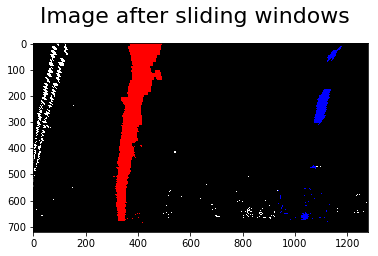

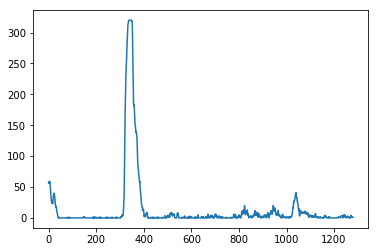

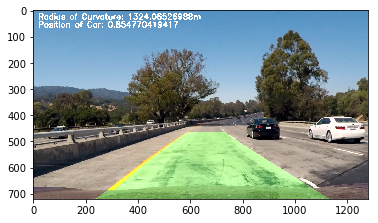

In [7]:
# Main function that process the image
# Including detecting lanelines, calculating curvature, visualization, calculating vehicle displacement from the middle of the lane

def sliding_windows(img, img_original, left_fit, right_fit):
    
    # Several Hpyerparameters
    window_width = 50
    window_height = 80
    nwindows = 9
    # the width of the windows +/- margin
    margin = 100
    # Minimum number of picxels found to reconter window
    minpix = 50
    
    ydir_max = img.shape[0]
    xdir_max = img.shape[1]
    
    # Find initial position
    # Using minpix menthod
    histogram = np.sum(img[ydir_max//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)

    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(ydir_max//nwindows)
    # Identify the x and y positon of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = left_base
    rightx_current = right_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    # If previous detection exists, search from prior
    if (np.count_nonzero(left_fit)+np.count_nonzero(right_fit)) == 0:
        for window in range(nwindows):
            # Boundaries
            win_y_low = ydir_max - (window+1)*window_height
            win_y_high = ydir_max - window*window_height
            # Corner of the windows
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the retangle
#             cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
#             cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
            # Find the idexes of the point that is believed to be in the lane lines
            current_left_inds = ((nonzeroy <= win_y_high)&(nonzeroy >= win_y_low)& \
                              (nonzerox <= win_xleft_high)&(nonzerox >= win_xleft_low)).nonzero()[0]
            current_right_inds = ((nonzeroy <= win_y_high)&(nonzeroy >= win_y_low)& \
                               (nonzerox <= win_xright_high)&(nonzerox >= win_xright_low)).nonzero()[0]

            left_lane_inds.append(current_left_inds)
            right_lane_inds.append(current_right_inds)

            if len(current_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[current_left_inds]))
            if len(current_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[current_right_inds]))
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoid an error if the above is not implemented fully
            pass
        
    else:
        left_lane_poly = np.poly1d(left_fit)
        left_lane_inds = ((nonzerox > (left_lane_poly(nonzeroy) - margin)) & \
                          (nonzerox < (left_lane_poly(nonzeroy) + margin)))
        right_lane_poly = np.poly1d(right_fit)
        right_lane_inds = ((nonzerox > (right_lane_poly(nonzeroy) - margin)) & \
                           (nonzerox < (right_lane_poly(nonzeroy) + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new Polynomials
    left_fit, right_fit, ploty, order_l, order_r = fit_polynomial(img, leftx, lefty, rightx, righty)
    left_poly = np.poly1d(left_fit)
    left_fitx = left_poly(ploty)
    right_poly = np.poly1d(right_fit)
    right_fitx = right_poly(ploty)
    
    # Visualization
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    # Try to fill the area between the two lines detected
    window_img = np.zeros_like(out_img)
    window_size = (out_img.shape[1], out_img.shape[0])
    lane_area_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_area_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_area = np.hstack((lane_area_right, lane_area_left))
    cv2.fillPoly(window_img, np.int_([lane_area]), (0, 255, 0))
    window_img = cv2.warpPerspective(window_img, M_bird_inv, window_size)
    img_original = cv2.addWeighted(img_original, 1, window_img, 0.3, 0)
    
    # measure curvature and put text on image
    left_curved, right_curved = measure_curvature(leftx, rightx, lefty, righty, ploty, order_l, order_r)
    if ((left_curved>1500) | (right_curved>1500)):
        radius = min(left_curved, right_curved)
    elif ((left_curved < 900) | (right_curved < 900)):
        radius = max(left_curved, right_curved)
    else:
        radius = (left_curved+right_curved)/2
    curvature_info = 'Radius of Curvature: ' + str(radius) + 'm'
    displacement_info = 'Position of Car: ' + str(((left_fitx[0] + right_fitx[0])/2 - out_img.shape[1]/2)*(3.7/700))
    font = cv2.FONT_HERSHEY_SIMPLEX
    img_copy = img_original.copy()
    img_original = cv2.putText(img_original, curvature_info, (20,35), font, 1, (255, 255, 255), 4)
    img_original = cv2.putText(img_original, displacement_info, (20,65), font, 1, (255, 255, 255), 4)
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, out_img, histogram, img_original

def best_poly_order(y, x):
    # 1st order
    poly1 = np.polyfit(y,x,1)
    p1 = np.poly1d(poly1)
    pred1 = p1(y)
    mse1 = mean_squared_error(x, pred1)
    # 2nd order
    poly2 = np.polyfit(y,x,2)
    p2 = np.poly1d(poly2)
    pred2 = p2(y)
    mse2 = mean_squared_error(x, pred2)
    # 3rd order
    poly3 = np.polyfit(y,x,2)
    p3 = np.poly1d(poly3)
    pred3 = p3(y)
    mse3 = mean_squared_error(x, pred3)
    minimum = mse1
    order = 1
    if minimum > mse2:
        minimum = mse2
        order = 2
    elif minimum > mse3:
        minimum = mse3
        order = 3
    
    if order == 1:
        return order, poly1
    elif order == 2:
        return order, poly2
    else:
        return order, poly3

def fit_polynomial(img, leftx, lefty, rightx, righty):
    # Fit the data using a 2nd order polynomial
    order_l, left_fit = best_poly_order(lefty, leftx)
    order_r, right_fit = best_poly_order(righty, rightx)
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    ## Visualization ##
    # Colors in the left and right lane regions
#     img[lefty, leftx] = [255, 0, 0]
#     img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    return left_fit, right_fit, ploty, order_l, order_r

left_fit = np.zeros(3)
right_fit = np.zeros(3)
leftx, lefty, rightx, righty, out_img, histogram_slidw, window_img = sliding_windows(birdeye_lanelines, test_image, left_fit, right_fit)
left_fit, right_fit, ploty, order_l, order_r = fit_polynomial(out_img, leftx, lefty, rightx, righty)

# Plot the output image
plt.figtext(0.5, 0.9, 'Image after sliding windows', fontsize = 22, ha='center')
plt.imshow(out_img)

plt.figure()
plt.plot(histogram_slidw)

plt.figure()
plt.imshow(window_img)

In [8]:
# Measure the curvature

left_curved, right_curved = measure_curvature(leftx, rightx, lefty, righty, ploty, order_l, order_r)
print(left_curved,'m', right_curved,'m')

1324.06526988 m 1531.66436157 m


In [9]:

def process_image(img):
    final_show, threshold_out, birdeye_lanelines, grad_combined, color_combined = Thresholding(img, M_bird)
    leftx, lefty, rightx, righty, out_img, histogram_slidw, window_img = sliding_windows(birdeye_lanelines, img, left_fit, right_fit)
    
    return window_img


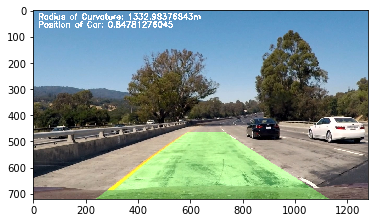

In [10]:
try_img = process_image(test_image)
plt.imshow(try_img)

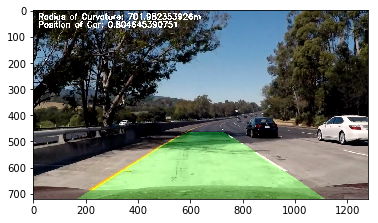

In [11]:
try_img = mpimg.imread("./test_images/test5.jpg")
try_out = process_image(try_img)
plt.imshow(try_out)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:57<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 4min 58s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
white_output = './challenge_video_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:58<00:00,  4.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

Wall time: 1min 59s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))